# Model Test Comparison

Our final step with our models is to test against our unseen data.  In this notebook we use our "test" dataset to see how each model performs. 

#### 1. [Installation and Importing of Libraries](#import)
#### 2. [Random Forest](#random_forest)
#### 3. [XGBoost](#xgboost)
#### 4. [XGBoost2](#xgboost2)
#### 5. [LightGBM](#lightgbm)

### <a name="import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries. The first cell installs packages necessary for Boruta.

In [1]:
!pip install --upgrade scikit-learn
!pip install cmake
!pip install xgboost

     |████████████████████████████████| 23.0MB 3.6MB/s eta 0:00:01    |████████▉                       | 6.4MB 3.6MB/s eta 0:00:05     |███████████▊                    | 8.4MB 3.6MB/s eta 0:00:05
     |████████████████████████████████| 307kB 16.0MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
     |████████████████████████████████| 25.0MB 3.6MB/s eta 0:00:01
     |████████████████████████████████| 798kB 3.5MB/s eta 0:00:01
  Created wheel for xgboost: filename=xgboost-1.6.2-cp37-cp37m-linux_x86_64.whl size=3142589 sha256=36842338941467d700fd9f8774276e3d6890a50e413048c4a53cac509b4661eb
  Stored in directory: /home/hallty/.cache/pip/wheels/66/2c/1a/50ebb2aee9e245fc0eb17b9739416203fd668312301278c901
Successfully built xgboost


In [3]:
!pip install lightgbm==3.3.5

     |████████████████████████████████| 2.0MB 3.5MB/s eta 0:00:01


In [3]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [5]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sklearn
import xgboost as xgb
import lightgbm as lgb
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score,\
classification_report, auc, recall_score, roc_curve, precision_score, precision_recall_curve, roc_auc_score, f1_score

In [6]:
print(sklearn.__version__)

1.0.2


In [6]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
def plot_roc_and_prc(y_test, y_pred_proc):
    fpr,tpr,_ = roc_curve(y_test, y_pred_proc)
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc)
    
    
    auc = roc_auc_score(y_test, y_pred_proc)
    
    ap = average_precision_score(y_test, y_pred_proc)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    
    
    ##plot ROC
    ax1.plot(fpr,tpr)
    ax1.plot([0,1],[0,1], "k-", color = "r",lw=1)
    ax1.annotate(f"AUC: {auc:.2f}",(.75,.25),weight="bold",size=14)
    ax1.set_ylabel('True Positive Rate/ Recall')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_title("ROC Curve")
    
    ##plot Precision-Recall Curve
    ax2.plot(recall,precision)
    ax2.set_ylabel("Precision")
    ax2.set_xlabel("Recall")
    ax2.set_title("Precision-Recall Curve")
    ax2.annotate(f"AP: {ap:.2f}",(.5,.75),weight="bold",size=14)
    
    plt.show()

In [10]:
def optimizedf1(y_test, y_pred_prob, target_recall_min = 0.0, target_recall_max = 1.0):

    
    precision,recall,threshold = precision_recall_curve(y_test, y_pred_prob,pos_label=1)
    
    fscore = np.nan_to_num((2 * precision * recall)\
                           / (precision + recall))
    
    precision_recall_table = {"precision": precision[:-1], "recall":recall[:-1],"threshold":threshold, "fscore":fscore[:-1]}
    precision_recall_table = pd.DataFrame(precision_recall_table)
    
    precision_recall_table = precision_recall_table[(precision_recall_table.recall > target_recall_min) & \
                                                   (precision_recall_table.recall < target_recall_max)].reset_index()
    
    
    
    index = np.argmax(precision_recall_table.fscore.values)
    
    return precision_recall_table.threshold[index]

In [15]:
def makeConfusionMatrixandScore(model,y_actual,X_set,thresh=0.5):
    ###A function for printing out a confusion matric and classification report
    ###to consistantly evaluate model performance
    if str(type(model)) == "<class 'xgboost.core.Booster'>":
        X_set =  xgb.DMatrix(X_set)
    
    y_pred_prob = model.predict(X_set)
    y_pred = pd.Series(y_pred_prob).apply(lambda x: 1 if x >= thresh else 0)
    
    cm = confusion_matrix(y_actual,np.round(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()    
    
    print(classification_report(y_actual, y_pred))

In [9]:
file_path = "/dsa/groups/casestudy2023su/team03/Data4/"

X_test = pd.read_csv(file_path + "X_test.csv")
y_test = pd.read_csv(file_path + "y_test.csv")

### <a name="random_forest"></a>Random Forest

In [11]:
# Paths to the saved models
model_file_path_rf = '/dsa/groups/casestudy2023su/team03/model_data/pickeled_models/random_forest_model.pkl'

with open(model_file_path_rf, 'rb') as file:
    data_loaded_rf = pickle.load(file)

loaded_model_rf = data_loaded_rf['model']
current_features_rf = data_loaded_rf['current_features']


In [12]:
current_features_rf

['index',
 'MHBW',
 'STANDSPER10SECTHOSEUNABLEREFUSEDSETTO0',
 'TAKEASPIRINATLEAST3XWEEK',
 'BMD_pca']

In [13]:
X_test_rf = X_test[current_features_rf]

missing_features = [feat for feat in current_features_rf if feat not in X_test.columns]
if len(missing_features) > 0:
    print("The following features are missing from the test set: ", missing_features)
else:
    print("All features are present in the test set.")


All features are present in the test set.


In [14]:
# Predict classes
rf_preds = loaded_model_rf.predict(X_test_rf)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_preds)
print("Accuracy for RF model: ", rf_accuracy)

# Predict probabilities
rf_probs = loaded_model_rf.predict_proba(X_test_rf)[:, 1]

# Calculate AUC
rf_auc = roc_auc_score(y_test, rf_probs)
print("AUC for RF model: ", rf_auc)

# Generate a classification report
rf_classification_report = classification_report(y_test, rf_preds)
print("Classification report for RF: ")
print(rf_classification_report)

Accuracy for RF model:  0.41402337228714525
AUC for RF model:  0.5763501857749469
Classification report for RF: 
              precision    recall  f1-score   support

           0       0.87      0.30      0.45       471
           1       0.24      0.84      0.38       128

    accuracy                           0.41       599
   macro avg       0.56      0.57      0.41       599
weighted avg       0.74      0.41      0.43       599



In [15]:
y_test_prob_rf = loaded_model_rf.predict_proba(X_test_rf)[:,1]

# Define thresholds
thresholds = np.arange(0.0, 1.05, 0.05)

# Calculate the f1-score for each threshold on class 1
f1_scores_rf = [f1_score(y_test, [1 if p >= thr else 0 for p in y_test_prob_rf]) for thr in thresholds]

# Find the threshold that gave the highest f1-score
best_thr_rf = thresholds[np.argmax(f1_scores_rf)]

print('Best Threshold for RF=%f, F1-Score=%.3f' % (best_thr_rf, np.max(f1_scores_rf)))

# Use the best threshold to convert probabilities to labels
adjusted_y_test_pred_rf = [1 if p >= best_thr_rf else 0 for p in y_test_prob_rf]

# Print out the classification reports
print(classification_report(y_test, adjusted_y_test_pred_rf))


Best Threshold for RF=0.650000, F1-Score=0.396
              precision    recall  f1-score   support

           0       0.88      0.39      0.54       471
           1       0.26      0.80      0.40       128

    accuracy                           0.48       599
   macro avg       0.57      0.60      0.47       599
weighted avg       0.75      0.48      0.51       599



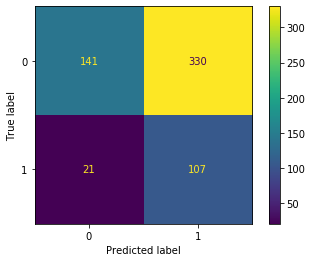

              precision    recall  f1-score   support

           0       0.87      0.30      0.45       471
           1       0.24      0.84      0.38       128

    accuracy                           0.41       599
   macro avg       0.56      0.57      0.41       599
weighted avg       0.74      0.41      0.43       599



In [16]:
thresh = optimizedf1(y_test, y_test_prob_rf, 0.78, 0.9)
makeConfusionMatrixandScore(loaded_model_rf, y_test, X_test_rf, thresh)

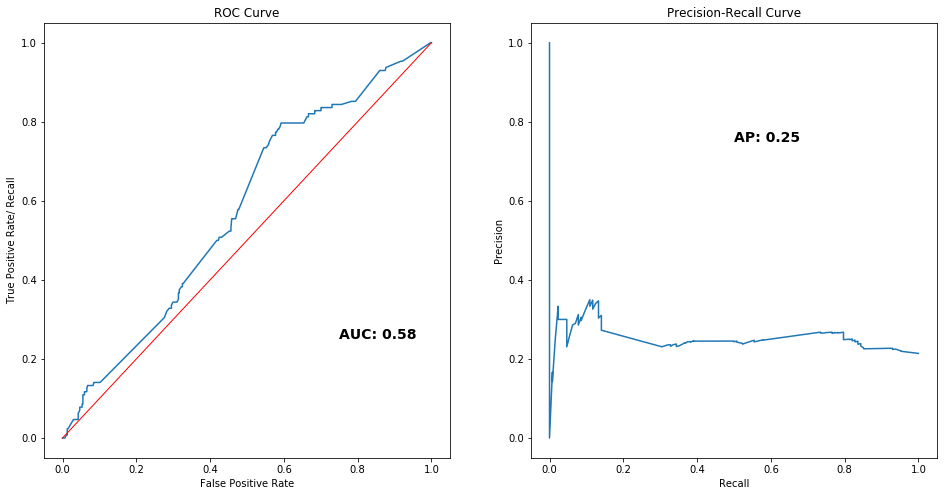

In [17]:
plot_roc_and_prc(y_test, y_test_prob_rf)

### <a name="xgboost"></a>XGBoost

In [7]:
#bst = b4 optuna and best_model = after optuna
bst_loaded = xgb.Booster()
bst_loaded.load_model('/dsa/groups/casestudy2023su/team03/model_data/pickeled_models/XGb4optuna.json')

best_model_loaded = xgb.Booster()
best_model_loaded.load_model('/dsa/groups/casestudy2023su/team03/model_data/pickeled_models/XGoptuna.json')


In [11]:
# Convert test data to DMatrix
dtest = xgb.DMatrix(X_test)

# Predict
bst_preds = bst_loaded.predict(dtest)
best_model_preds = best_model_loaded.predict(dtest)

bst_preds_binary = (bst_preds > 0.5).astype(int)
best_model_preds_binary = (best_model_preds > 0.5).astype(int)

bst_accuracy = accuracy_score(y_test, bst_preds_binary)
best_model_accuracy = accuracy_score(y_test, best_model_preds_binary)

print("Accuracy for bst model: ", bst_accuracy)
print("Accuracy for best_model: ", best_model_accuracy)

# Calculate AUC for the bst model
bst_auc = roc_auc_score(y_test, bst_preds)
print("AUC for bst model: ", bst_auc)

# Calculate AUC for the best_model
best_model_auc = roc_auc_score(y_test, best_model_preds)
print("AUC for best_model: ", best_model_auc)


Accuracy for bst model:  0.7796327212020033
Accuracy for best_model:  0.7796327212020033
AUC for bst model:  0.6194267515923566
AUC for best_model:  0.6343550955414012


In [12]:
# classification report for b4 optuna
bst_classification_report = classification_report(y_test, bst_preds_binary)
print("Classification report for XG before optuna: ")
print(bst_classification_report)

# classification report for optuna
best_model_classification_report = classification_report(y_test, best_model_preds_binary)
print("Classification report for XG after optuna: ")
print(best_model_classification_report)


Classification report for XG before optuna: 
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       471
           1       0.41      0.07      0.12       128

    accuracy                           0.78       599
   macro avg       0.60      0.52      0.50       599
weighted avg       0.71      0.78      0.71       599

Classification report for XG after optuna: 
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       471
           1       0.43      0.10      0.16       128

    accuracy                           0.78       599
   macro avg       0.62      0.53      0.52       599
weighted avg       0.72      0.78      0.72       599



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


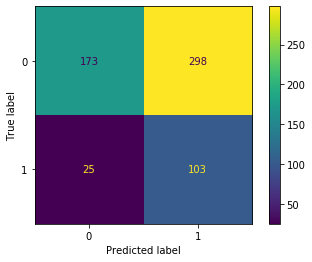

              precision    recall  f1-score   support

           0       0.87      0.37      0.52       471
           1       0.26      0.80      0.39       128

    accuracy                           0.46       599
   macro avg       0.57      0.59      0.45       599
weighted avg       0.74      0.46      0.49       599



In [16]:
y_test_prob_best_model = best_model_loaded.predict(dtest)
thresh = optimizedf1(y_test, y_test_prob_best_model, 0.78, 0.9)
makeConfusionMatrixandScore(best_model_loaded, y_test, X_test, thresh)

In [46]:
#build a function for threshold categorization
def categorize_risk(probability, low_risk_threshold, medium_risk_threshold):
    if probability <= low_risk_threshold:
        return 'low'
    elif probability <= medium_risk_threshold:
        return 'medium'
    else:
        return 'high'

# Define thresholds
low_risk_threshold = 0.2
medium_risk_threshold = 0.6

y_test_flat = y_test.values.ravel()

# Use your function to categorize the risks
risk_categories = [categorize_risk(p, low_risk_threshold, medium_risk_threshold) for p in y_test_prob_best_model]

# Create a DataFrame for evaluation
df_evaluation = pd.DataFrame({'RiskCategory': risk_categories, 'ActualOutcome': y_test_flat})

# Calculate mean and sum of ActualOutcome within each RiskCategory
mean_outcomes = df_evaluation.groupby('RiskCategory')['ActualOutcome'].mean()
sum_outcomes = df_evaluation.groupby('RiskCategory')['ActualOutcome'].sum()

# Print outcomes
print(mean_outcomes)
print(sum_outcomes)



RiskCategory
high      0.454545
low       0.134831
medium    0.271028
Name: ActualOutcome, dtype: float64
RiskCategory
high       5
low       36
medium    87
Name: ActualOutcome, dtype: int64


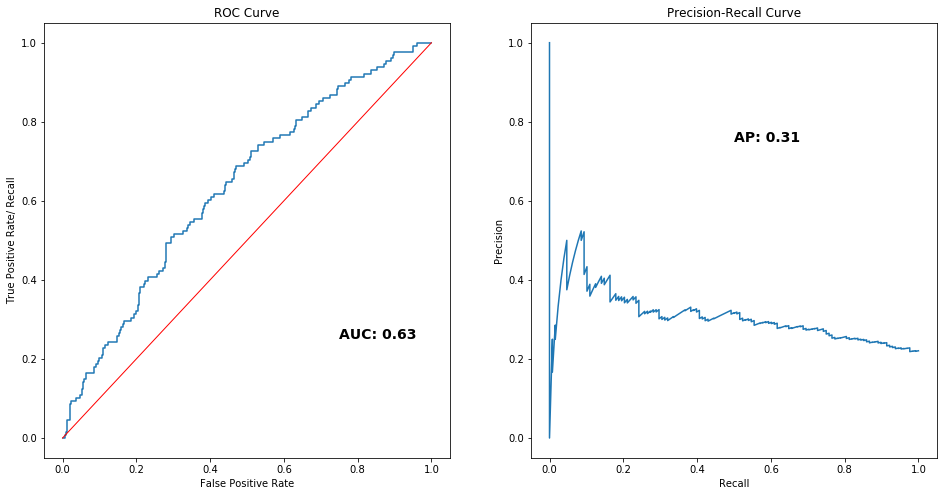

In [24]:
plot_roc_and_prc(y_test, y_test_prob_best_model)

### <a name="xgboost2"></a>XGBoost2

In [25]:
xgb2 = xgb.Booster()
xgb2.load_model('/dsa/groups/casestudy2023su/team03/model_data/pickeled_models/XGBmodel6.json')

In [26]:
# Predict using the xgb2 model
X_test_xgb2 = X_test
X_test_xgb2.columns = X_test_xgb2.columns.str.upper()
dtestxgb2 = xgb.DMatrix(X_test_xgb2)
xgb2_preds = xgb2.predict(dtestxgb2)
xgb2_preds_binary = (xgb2_preds > 0.5).astype(int)
xgb2_accuracy = accuracy_score(y_test, xgb2_preds_binary)
xgb2_auc = roc_auc_score(y_test, xgb2_preds)
xgb2_classification_report = classification_report(y_test, xgb2_preds_binary)

# Print the results
print("Accuracy for xgb2 model: ", xgb2_accuracy)
print("AUC for xgb2 model: ", xgb2_auc)
print("Classification report for xgb2 model: ")
print(xgb2_classification_report)

Accuracy for xgb2 model:  0.7846410684474123
AUC for xgb2 model:  0.6222797239915074
Classification report for xgb2 model: 
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       471
           1       0.47      0.06      0.11       128

    accuracy                           0.78       599
   macro avg       0.63      0.52      0.49       599
weighted avg       0.72      0.78      0.71       599



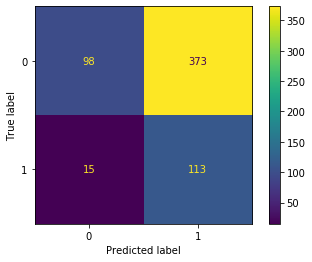

              precision    recall  f1-score   support

           0       0.87      0.21      0.34       471
           1       0.23      0.88      0.37       128

    accuracy                           0.35       599
   macro avg       0.55      0.55      0.35       599
weighted avg       0.73      0.35      0.34       599



In [27]:
thresh = optimizedf1(y_test, xgb2_preds, 0.78, 0.9)
makeConfusionMatrixandScore(xgb2, y_test, X_test_xgb2, thresh)

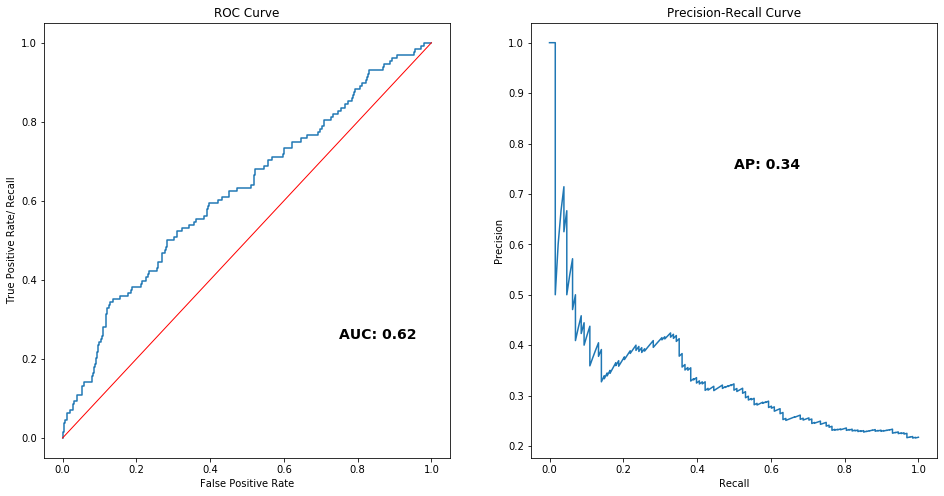

In [28]:
plot_roc_and_prc(y_test,xgb2_preds)

### <a name="lightgbm"></a>LIghtGBM

In [64]:
features = joblib.load("/dsa/groups/casestudy2023su/team03/merged_data/LGBM/features.pkl")
X_test_LGB = X_test[features]

In [65]:
lgb = joblib.load("/dsa/groups/casestudy2023su/team03/merged_data/LGBM/LGBMoptuna_resample_cv.pkl")

In [66]:
y_pred = lgb.predict(X_test_LGB)

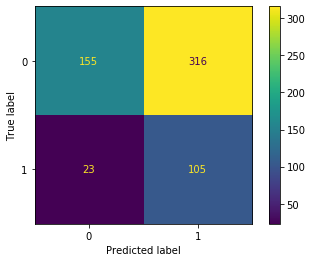

              precision    recall  f1-score   support

           0       0.87      0.33      0.48       471
           1       0.25      0.82      0.38       128

    accuracy                           0.43       599
   macro avg       0.56      0.57      0.43       599
weighted avg       0.74      0.43      0.46       599



In [67]:
thresh = optimizedf1(y_test,y_pred,0.78,0.9)
makeConfusionMatrixandScore(lgb, y_actual=y_test, X_set=X_test_LGB ,thresh=thresh)

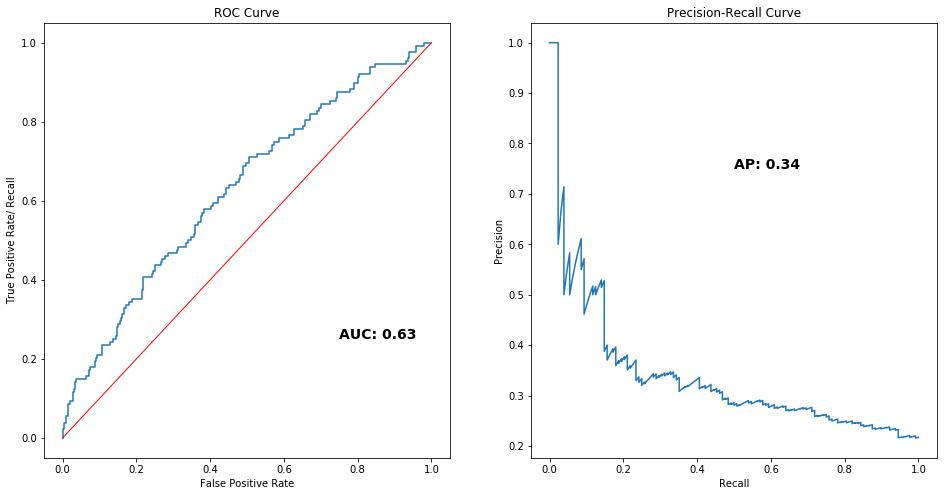

In [68]:
plot_roc_and_prc(y_test,y_pred)